# Tight-Binding Models Starter Kit

This Python Jupyter notebook is intended to get the reader started on doing simple calculations with tight-binding models. It covers:

* A review of single-particle tight-binding models
* Simple code to create Hamiltonian matrices for such models
* Examples of numerical calculations with the SSH and Haldane models
* Calculations of the Berry connection, Berry curvature, and the Chern number

The reader is assumed to know quantum mechanics at an advanced (3rd or 4th year) undergraduate level. The numerical examples will use only basic Numpy/Scipy, rather than specialized Python libraries.

In [1]:
%matplotlib inline
## Import Numpy and Scipy libraries
import numpy as np
import scipy.linalg
import scipy.sparse as sp
import matplotlib.pyplot as plt

## Tight-Binding Models

A single-particle tight-binding model is a class of theoretical models, widely-used in condensed matter physics and related disciplines, that describes a quantum mechanical particle that can hop between different sites on a discrete lattice. Let the sites be labeled by some discrete indices $\{n\}$ (e.g., an integer or multiplet of integers). Let $|\psi\rangle$ be a solution to the time-independent Schrodinger equation,

$$\hat{H} |\psi\rangle = E |\psi\rangle.$$

Let $|n\rangle$ denote a "position eigenstate" where the particle is located at site $n$. If we use these as a basis,

$$|\psi\rangle = \sum_n \psi_n |n\rangle,$$

then the time-independent Schrodinger equation reduces to the matrix equation

$$\sum_{nn'} H_{nn'}\psi_{n'} = E\psi_n, \quad H_{nn'} = \langle n|\hat{H}|n'\rangle.$$

It is also common to express this using second quantized notation.  Defining creation and annihilation operators $\hat{a}_n^\dagger$ and $\hat{a}_n$ (either bosonic or fermionic; it doesn't matter for single-particle models), we can define the position eigenstates with respect to a vacuum state $|\varnothing\rangle$ by

$$|n\rangle = \hat{a}_n^\dagger|\varnothing\rangle.$$

Then the second quantized Hamiltonian can be written as

$$\hat{H} = \sum_{nn'} H_{nn'} \hat{a}_n^\dagger \hat{a}_{n'}.$$

Proof:

$$\begin{aligned}\langle n | \left(\sum_{mm'} H_{mm'} \hat{a}_m^\dagger \hat{a}_{m'} \right) |n'\rangle &= \sum_{mm'} H_{mm'} \langle \varnothing | \hat{a}_n \hat{a}_m^\dagger \hat{a}_{m'} \hat{a}_{n'}^\dagger |\varnothing\rangle \\ &= \sum_{mm'} H_{mm'} \delta_{nm} \delta_{n'm'} \\ &= H_{nn'}\end{aligned}$$

We can also see from this that $H_{mn}$ refers to hopping from $n$ to $m$ (i.e., from the right index to the left index), not the other way round.

### 1D Chain with Nearest Neighbor Hoppings

Consider $N$ sites arranged along a linear chain, with a "hopping" of $t \in \mathbb{R}$ between nearest neighbors:

<div align="center"><img src="chain1d.png" /></div>

In this case, the sites can be indexed by integers $n = 0, \dots, N-1$ (we start from 0 because that's how Python does it). The Hamiltonian matrix elements are given by

$$H_{n\pm 1, n} = t$$

This formula is subject to "open" boundary conditions: e.g., $H_{01}$ is ignored since that falls outside the lattice. Such a Hamiltonian is easy to set up:

In [2]:
## Return the Hamiltonian for a simple finite chain of hopping t, as a sparse 2D array.
def lattice_simple_chain_finite(N, t):
    offdiag = np.empty(N-1); offdiag.fill(t)
    return sp.dia_matrix(([offdiag, offdiag], [-1,1]), shape=(N,N))

Note: for 1D lattice problems, it is not really necessary to use [sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html), but it's good practice nonetheless since the matrices *are* sparse.

We are often interested in comparing the finite lattice to its infinite-sized counterpart, whose properties are accessible via Bloch's theorem. In the infinite system, the sites are indexed by $n \in \mathbb{Z}$. The Bloch wavefunction is given by

$$\psi_n = \psi e^{ikn},$$

where $k \in [-\pi, \pi]$ is the quasi-momentum running over the 1D Brillouin zone. Plugging this into Schrodinger's equation yields

$$\begin{aligned}H_{n,n-1} \psi_{n-1} + H_{n,n+1} \psi_{n+1} &= E \psi_n \\ t \psi e^{ik(n-1)} + t \psi e^{ik(n+1)} &= \psi e^{ikn} \\ E &= 2t \cos k  \end{aligned}$$

In the code below, we compare the spectra of the finite and infinite lattices. The results show that the finite lattice, for sufficiently large $N$, spans the same energy range as the band energies of the infinite lattice, as expected:

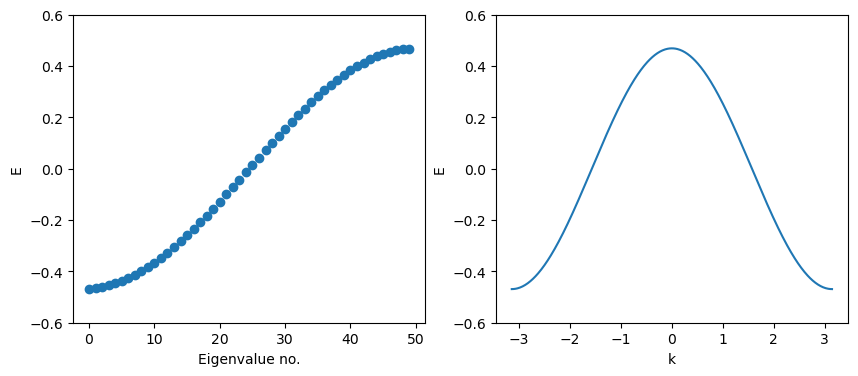

In [3]:
def test_simple_chain_spectrum():
    t = 0.2345

    ## Plot the spectrum of the finite chain
    N = 50
    H = lattice_simple_chain_finite(N, t)
    E = scipy.linalg.eigvalsh(H.todense()) # Just get all the eigenvalues
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(E, 'o')
    plt.xlabel('Eigenvalue no.')
    plt.ylabel('E')
    plt.ylim(-0.6, 0.6)

    ## Plot the band energies:
    plt.subplot(1,2,2)
    k  = np.linspace(-np.pi, np.pi, 500)
    Ek = 2*t*np.cos(k)
    plt.plot(k, Ek)
    plt.ylim(-0.6, 0.6)
    plt.xlabel('k')
    plt.ylabel('E')
    plt.show()

test_simple_chain_spectrum()

## SSH Model (1D)

The SSH (Su-Schrieffer-Heeger) model is a 1D tight-binding model that serves as a workhorse model for understanding band topology. Similar to the previous model, the sites are laid out in a chain, with nearest neighbor hoppings, but with two inequivalent atoms per unit cell:

<div align="center"><img src="ssh.png" /></div>

Instead of simply indexing the sites by integers, it is more rational to give each cell the index $(n, s)$, where $n = 1, \dots, N$ is the cell index and $s \in \{A, B\}$ denotes the site in sublattice $A$ or $B$, as shown in the schematic above. The hoppings are $t_1$ between sites in the same cell, and $t_2$ between sites in adjacent cells (both hopping parameters are real). Thus, the Hamiltonian matrix elements have the form

$$\begin{aligned} H_{(n,B),(n,A)} &= H_{(n,A),(n,B)} =  t_1 \\ H_{(n,A),(n-1,B)} &= H_{(n,B),(n+1,A)} = t_2 \\ H_{(n,A),(n,A)} &= E_A \\ H_{(n,B),(n,B)} &= E_B \end{aligned}$$

For the finite lattice, these are subject to the same open boundary conditions as before. For generality, we have added on-site energies $E_A$ and $E_B$ on the $A$ and $B$ sites respectively (the true SSH model has $E_A = E_B = 0$).

Note that we have specified four equations for the hoppings, corresponding to the four distinct kinds of arrows (corresponding to hopping processes) in the lattice schematic, taking the directionality of the arrows into account. We don't need to specify more than four equations; that would be redundant, because of the periodicity of the lattice. In the above equations, we have chosen to phrase the equations in terms of all hoppings *into* the two sites on cell $n$, i.e., $(n,A)$ and $(n,B)$. This is just a choice, but it's convenient because it allows us to fill in the Hamiltonian matrix elements $\{H_{nn'}\}$ row-wise, by iterating over $n$, and looking through all the possible $n'$ that hop into $n$.

We now face the problem that matrices (or rather Python arrays) have to be indexed using integers. To get around this, we construct a mapping between *model* indices of the form $(n,A/B)$ (i.e., the indices that the tight-binding model is expressed in) and *internal* indices (i.e., integers that enumerate the sites). For 1D chains like this, it is not too difficult to devise such a mapping by hand. However, we will encounter the same issue in more complicated settings (particularly 2D and 3D lattices), so it will be good to solve the general problem now.

The approach we take is to generate an array of possible model indices, like this `[(1,A), (1,B), ...]`, such that each element of the array is a Python object that corresponds to a given model index. This array thus serves as a map from internal indices to model indices. Then we generate the reverse map, by constructing a Python dictionary that takes model indices as keys, and internal indices as values.

This is implemented by defining a `lattice` Python class, defined below. This class takes an array of model indices, and sets up the necessary Python dictionary. It also offers an `add_hopping` method that can be used to add specific elements to a matrix, specified in terms of the model index rather than the internal index.

In [14]:
class lattice:
    def __init__(self, model_indices):
        ## Given an array of model indices, generate the reverse map as a dict:
        self.indices = { idx: k for k, idx in enumerate(model_indices) }

    ## Add a hopping to the Hamiltonian matrix from 'fromsite' to 'tosite', but
    ## only if 'fromsite' exists in the lattice.
    def add_hopping(self, H, tosite, fromsite, value):
        if fromsite in self.indices:
            H[self.indices[tosite], self.indices[fromsite]] += value

    def __len__(self):
        return len(self.indices)

Now we use this to generate a SSH Hamiltonian. Below, the `lattice_ssh_finite` function returns the Hamiltonian matrix, along with the lattice object.

The actual construction of the Hamiltonian matrix occurs in a `hamiltonian_ssh` helper function, which takes the lattice object and returns the appropriate SSH Hamiltonian. Splitting off construction of the Hamiltonian matrix will be helpful later, when we want to consider 2D lattices of different shapes: we can use different `lattice_*_finite` functions for different samples, and then call the same `hamiltonian_*` helper function to build the Hamiltonian.

In [15]:
## Construct the Hamiltonian matrix for an SSH model with parameters t1, t2, EA, EB,
## with N unit cells (i.e., 2N sites).  Return H, idx, imap, where H is the
## Hamiltonian matrix, idx is the array of model indices, and imap maps model
## indices to numerical indices.
def lattice_ssh_finite(N, t1, t2, EA, EB):
    ## Loop over unit cells, registering sites
    idx = []
    for n in range(N):
        idx.append((n, 'A'))
        idx.append((n, 'B'))
    latt = lattice(idx)
    H    = hamiltonian_ssh(latt, t1, t2, EA, EB)
    return H, latt

## Helper function for lattice_ssh_finite: construct the Hamiltonian matrix
## using the lattice specified by `idx' and `imap'.
def hamiltonian_ssh(latt, t1, t2, EA, EB):    
    N = len(latt)
    H = sp.lil_matrix((N, N), dtype=complex)            # Prepare an empty sparse matrix
    for idx in latt.indices:
        n, s = idx
        if s == 'A':
            latt.add_hopping(H, idx, idx, EA)
            latt.add_hopping(H, idx, (n, 'B'), t1)     # intra-cell
            latt.add_hopping(H, idx, (n-1, 'B'), t2)   # inter-cell
        else:
            latt.add_hopping(H, idx, idx, EB)
            latt.add_hopping(H, (n, s), (n, 'A'), t1)   # intra-cell
            latt.add_hopping(H, (n, s), (n+1, 'A'), t2) # inter-cell

    return H.tocsc()

Next, let us construct the Bloch Hamiltonian for the SSH model. Take the Bloch ansatz

$$\begin{aligned}\psi_{n,A} &= \psi_A e^{ikn} \\ \psi_{n,B} &= \psi_B e^{ikn}\end{aligned}$$

and plug it into the Schrodinger equation:

$$\begin{aligned} H_{(n,A),(n-1,B)} \psi_{n-1,B} + H_{(n,A),(n,A)} \psi_{n,A} + H_{(n,A),(n,B)} \psi_{n,B} &= E \psi_{n,A} \\ H_{(n,B),(n,A)} \psi_{n,A} + H_{(n,B),(n,B)} \psi_{n,B} + H_{(n,B),(n+1,A)} \psi_{n+1,A} &= E \psi_{n,B} \end{aligned}$$

Here we have included only the non-vanishing matrix elements (as specified above). These equations simplify to

$$\begin{pmatrix}E_A & t_1 + t_2 e^{-ik} \\t_1 + t_2 e^{ik} & E_B\end{pmatrix} \begin{pmatrix}\psi_A \\ \psi_B\end{pmatrix} = E \begin{pmatrix}\psi_A \\ \psi_B\end{pmatrix}.$$

Let us compare once again the spectra for the finite and infinite lattices:

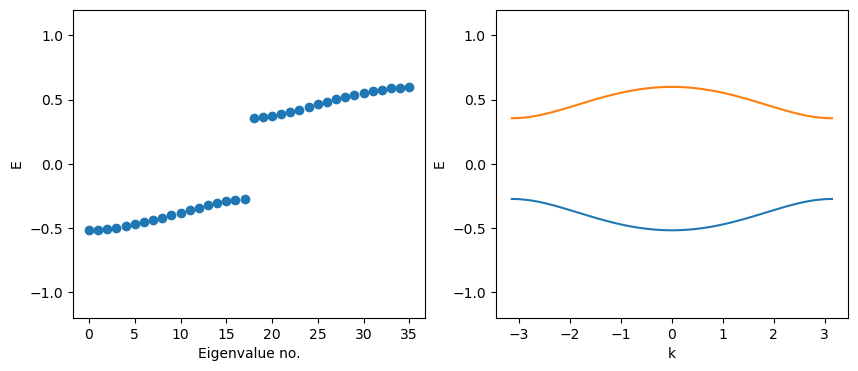

In [16]:
def test_ssh_spectrum():
    t1, t2 = 0.4321, 0.1234
    EA, EB = 0.1, -0.02
    
    ## Plot the spectrum of the finite chain
    N = 18
    H, _ = lattice_ssh_finite(N, t1, t2, EA, EB)
    E = scipy.linalg.eigvalsh(H.todense()) # Just get all the eigenvalues
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(E, 'o')
    plt.xlabel('Eigenvalue no.')
    plt.ylabel('E')
    plt.ylim(-1.2, 1.2)

    ## Spectrum of the infinite (BLoch) system
    plt.subplot(1,2,2)
    k  = np.linspace(-np.pi, np.pi, 300)
    Ek = np.empty((len(k), 2))
    for n in range(len(k)):
        kk = k[n]
        Hk = np.array([[EA, t1+t2*np.exp(-1j*kk)], [t1+t2*np.exp(1j*kk), EB]])
        Ek[n] = scipy.linalg.eigvalsh(Hk)
    plt.plot(k, Ek[:,0])
    plt.plot(k, Ek[:,1])
    plt.xlabel('k')
    plt.ylabel('E')
    plt.ylim(-1.2, 1.2)
    plt.show()

test_ssh_spectrum()

There are two bands, consistent with the fact that there are two atoms per unit cell. Once again, the energy bands of the finite lattice span the same ranges of energy as those of the Bloch ansatz, including the presence of a band gap separating the two bands.

Feel free to plug in different parameters into the above code, and see how the spectra change. Notably, if you set $t_1 < t_2$, you will observe that the finite lattice has two isolated energy eigenvalues inside the band gap. These are the "topological edge states" of the SSH model. Try plotting the spatial distributions of these special eigenstates — you should see that they are exponentially localized to the edges of the 1D lattice.

## Hofstadter Model (2D)

The Hofstadter Model is a toy model for a 2D electron gas in a perpendicular (out-of-plane) uniform magnetic field. The electrons live on a discrete square lattice, oriented in the $x$-$y$ plane, whose sites can be labeled by a duple of integers, $n = (x, y)$, where $x, y \in \mathbb{Z}$. The magnetic vector potential is given by the Landau gauge

$$\mathbf{A}(x,y) = B a \begin{pmatrix}-y\\ 0 \\ 0\end{pmatrix},$$

where $a$ is the lattice spacing. This corresponds to a magnetic field $\mathbf{B} = B\vec{z}$. Note that this $\mathbf{A}$ field manifestly breaks translational symmetry along the $y$ direction.

Generally, introducing a magnetic vector potential to a tight-binding model alters the inter-site hoppings by adding a phase (this is called the "Peierls substitution"):

$$H_{nn'} \rightarrow H_{nn'} e^{i\phi_{nn'}}, \quad\mathrm{where}\;\;\; \phi_{nn'} = - \frac{e}{\hbar} \int_{n'}^{n} \mathbf{A} \cdot d\mathbf{r},$$

The line integral can be taken along any path from $n'$ to $n$, but is usually taken along the straight line joining the two sites. Note: this can be seen from gauge symmetry. If $\psi$ is an eigenstate of a Hamiltonian of energy $E$, after we do a gauge transformation $\tilde{\mathbf{A}} = \mathbf{A} + \nabla \Lambda$, then $\tilde{\psi} = \psi \exp(-ie\Lambda/\hbar)$ must be an eigenstate of the gauge transformed Hamiltonian with the same energy. With the above prescription, this is satisfied since

$$\begin{aligned}\sum_{n'} \tilde{H}_{nn'} \tilde{\psi}_{n'} &= \sum_{n'} H_{nn'} \exp\left[-\frac{ie}{\hbar} \int_{n'}^{n} \nabla \Lambda \cdot d\mathbf{r}\right] \psi_{n'} \exp\left[-\frac{ie\Lambda_{n'}}{\hbar}\right] \\ &= \left(\sum_{n'} H_{nn'} \psi_{n'}\right) \exp\left[-\frac{ie\Lambda_n}{\hbar}\right] \\ &= E \tilde{\psi}_n.\end{aligned}$$

A schematic of the lattice is shown below. There are four kinds of hoppings to take into account, corresponding to the $\pm x$ and $\pm y$ directions. The hoppings hoppings along $\pm x$ are altered by phase factors (to be specified below), due to the vector potential. The hoppings along $\pm y$ are unaffected, because in the Landau gauge it is oriented along the $x$ direction. Since the $y$ hoppings are the same in the forward and backward directions, we will draw them as lines without arrows, for simplicity; just remember that each one of these represents a forward and a backward arrow.

<div align="center"><img src="hofstadter.png" /></div>

We will now state the lattice Hamiltonian. We need to specify four hoppings, and as before, it will be convenient to phrase things in terms of the hoppings going *into* site $(x,y)$:

$$\begin{aligned}H_{(x,y),(x+1,y)} &= t \exp(-ieBa^2y/\hbar) \\ H_{(x,y),(x-1,y)} &= t \exp(ieBa^2y/\hbar) \\ H_{(x,y),(x,y+1)} &= H_{(x,y),(x,y-1)} = t\end{aligned}$$

Here, the phase factors are obtained by using the Peierls substitution along with the Landau gauge. For example, in the first line, we obtain the phase as follows (remember that the $x$ and $y$ indices are integers):

$$\begin{aligned} - \frac{e}{\hbar} \;a \int_{x+1}^{x} A_x(x') \;dx' &= - \frac{ea}{\hbar} \int^{x}_{x+1} (-Bay) \; dx' \\ &= \frac{eBa^2y}{\hbar} \int^{x}_{x+1} dx' \\ &= \frac{eBa^2y}{\hbar}.\end{aligned}$$

Now we can write a function to set up a Hamiltonian for a finite lattice:

In [23]:
## This function uses the `index_map' and `add_hopping' subroutines defined earlier.

## Construct the Hamiltonian matrix for a Hofstadter model with parameters t and B,
## with N sites in the x and y directions (i.e., N^2 sites in total).
## We will take computational units e = hbar = a = 1.
## Return H, idx, imap, where H is the Hamiltonian matrix, idx is the array
## of model indices, and imap maps model indices to numerical indices.
def lattice_hofstadter_finite(N, t, B):
    ## Loop over unit cells, registering sites
    idx = []
    for x in range(N):
        for y in range(N):
            idx.append((x, y))
    latt = lattice(idx)
    H    = hamiltonian_hofstadter(latt, t, B)
    return H, latt

def hamiltonian_hofstadter(latt, t, B):
    N = len(latt)
    H = sp.lil_matrix((N, N), dtype=complex)
    for r in latt.indices:
        x, y = r
        Phi = B*y
        latt.add_hopping(H, r, (x+1,y), t*np.exp(-1j*Phi))
        latt.add_hopping(H, r, (x-1,y), t*np.exp(1j*Phi))
        latt.add_hopping(H, r, (x,y+1), t)
        latt.add_hopping(H, r, (x,y-1), t)
    return H.tocsc()

Let's check out the energy spectrum:

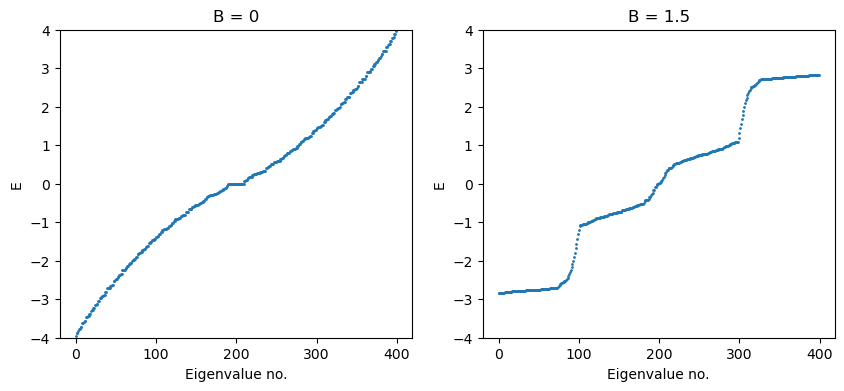

In [24]:
def test_hofstadter_spectrum():
    t = 1.0
    N = 20
    
    ## Plot the spectrum of the Hofstadter model for B = 0 and B = 0.5
    H, _ = lattice_hofstadter_finite(N, t, 0)
    E = scipy.linalg.eigvalsh(H.todense()) # Just get all the eigenvalues
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title('B = 0')
    plt.plot(E, 'o', markersize=1)
    plt.xlabel('Eigenvalue no.')
    plt.ylabel('E')
    plt.ylim(-4, 4)

    B = 1.5
    H, _ = lattice_hofstadter_finite(N, t, B)
    E = scipy.linalg.eigvalsh(H.todense()) # Just get all the eigenvalues
    plt.subplot(1,2,2)
    plt.title('B = {}'.format(B))
    plt.plot(E, 'o', markersize=1)
    plt.xlabel('Eigenvalue no.')
    plt.ylabel('E')
    plt.ylim(-4, 4)

    ## Add Landau levels for comparison
    for n in range(-3,4):
        E = (n)
    
    plt.show()

test_hofstadter_spectrum()

For $B \ne 0$, the energy spectrum starts breaking up into a set of nearly-degenerate levels, called Landau levels. The Landau levels are not cleanly separated in energy because of the existence of "topological edge states", which can be shown to be localized to the edge of the lattice.

There are many avenues for exploring this model in further detail. For example,

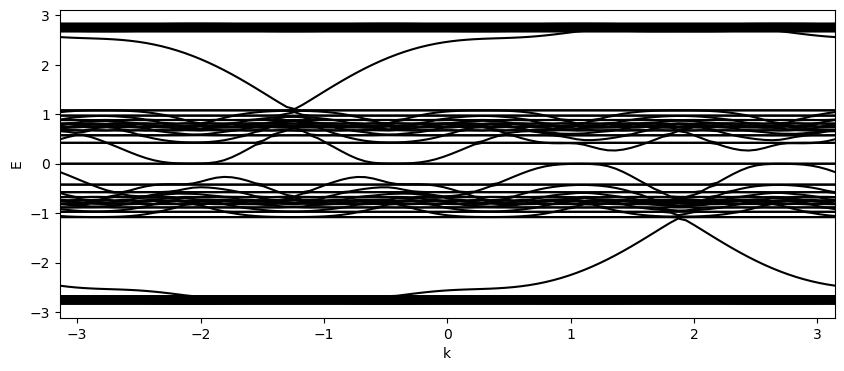

In [25]:
## Return the Hofstadter Hamiltonian for a lattice that has length N
## along y, and Bloch boundary conditions (with wavenumber k) along x.
def hamiltonian_hofstadter_bloch(latt, t, B, k):
    N = len(latt)
    H = sp.lil_matrix((N, N), dtype=complex)
    for y in latt.indices:
        Phi = B*y
        latt.add_hopping(H, y, y, t*np.exp(1j*(k-Phi)))  # Hop from right (with Bloch phase shift)
        latt.add_hopping(H, y, y, t*np.exp(1j*(-k+Phi))) # Hop from left  (with Bloch phase shift)
        latt.add_hopping(H, y, y+1, t)
        latt.add_hopping(H, y, y-1, t)
    return H.tocsc()

def test_hofstadter_spectrum_bloch():
    t = 1.0
    N = 90
    B = 1.525
    
    latt = lattice(np.arange(N))
    
    kvec = np.linspace(-np.pi, np.pi, 100)
    E = np.empty((len(kvec), N))
    for n in range(len(kvec)):
        H = hamiltonian_hofstadter_bloch(latt, t, B, kvec[n])
        E[n] = scipy.linalg.eigvalsh(H.todense())

    plt.figure(figsize=(10,4))
    for m in range(N):
        plt.plot(kvec, E[:,m], 'k')
    plt.xlabel('k')
    plt.ylabel('E')
    plt.xlim(-np.pi, np.pi)
    plt.show()

test_hofstadter_spectrum_bloch()

## Haldane model (2D)

The [Haldane model](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.61.2015) is a workhorse model for understanding 2D topological insulators. The lattice structure is shown schematically below. It consists of a honeycomb lattice, which has two atoms per unit cell (labeled $A$ and $B$, and colored in red and blue respectively).

<div align="center"><img src="haldane1.png" /></div>

There are two kinds of hoppings in the lattice: (i) nearest neighbor (NN) hoppings of amplitude $t_1$ between $A$ sites and $B$ sites (black lines), and (ii) next-nearest neighbor (NNN) hoppings between two $A$ sites (red arrows) or two $B$ sites (blue arrows). The NNN hoppings are subject to a vector potential-induced phase shift $\phi$, such that the hopping is $t_2\exp(i\phi)$ in the direction of the arrow, and $t\exp(-i\phi)$ in the direction opposite to the arrow (the forward and backward hoppings are complex conjugates due to Hermiticity). It can be shown that this pattern of hoppings corresponds to a nonzero magnetic fields but *zero* net magnetic flux through each unit cell. Unlike the Hofstadter model, the Haldane model possesses the same translational symmetries as the underlying honeycomb lattice.

To index the sites, it is helpful to define non-orthogonal axes $m$ and $n$, oriented along two of the principal axes of the honeycomb lattice, as shown below. A typical unit cell, shaded in green, is indexed by two integers $(m,n)$. It contains two sites, indexed as $(m,n,A)$ or $(m,n,B)$.

<div align="center"><img src="haldane2.png" /></div>

In the schematic, we have drawn only the hoppings attached to either of these two sites. As before, when we construct the Hamiltonian row-wise, we will account for hoppings *to* these two sites. These consist of:

* 2 NN intra-cell hoppings
* 4 NN hoppings to sites on adjacent cells
* 6 $A$-type NNN hoppings
* 6 $B$-type NNN hoppings

for a total of 18 hoppings! As a reminder, the NN hoppings are $t_1$, and the NNN hoppings are $t_2 \exp(\pm i \phi)$ (with the $\pm$ determined by the arrow directions in the schematic). In addition, the Hamiltonian contains on-site energies of $+M$ (for the $A$ sites) and $-M$ (for the $B$ sites).

This looks bad, but is actually not too difficult to construct using our coding framework, as shown below:

In [ ]:
def lattice_haldane_finite_triangle(N, M, t1, t2, phi):
    ## Loop over unit cells, registering sites
    idx = []
    for m in range(N):
        for m in range(N):
            idx.append((m, n))
    latt = lattice(idx)
    return hamiltonian_haldane(latt, M, t1, t2, phi), latt

def hamiltonian_haldane(latt, M, t1, t2, phi):
    N = len(latt)
    H = sp.lil_matrix((N, N), dtype=complex)

    t2f = t2*np.exp(1j*phi)  # Forward NNN hopping
    t2b = t2*np.exp(-1j*phi) # Backward NNN hopping

    for idx in latt.indices:
        m, n, s = idx
        if s == 'A':
            latt.add_hopping(H, idx, idx, M)
            ## NN hoppings
            latt.add_hopping(H, idx, (m,   n,   'B'), t1)
            latt.add_hopping(H, idx, (m+1, n-1, 'B'), t1)
            latt.add_hopping(H, idx, (m,   n-1, 'B'), t1)
            ## NNN hoppings
            latt.add_hopping(H, idx, (m+1, n,   'A'), t2f)
            latt.add_hopping(H, idx, (m-1, n+1, 'A'), t2f)
            latt.add_hopping(H, idx, (m,   n-1, 'A'), t2f)
            latt.add_hopping(H, idx, (m,   n+1, 'A'), t2b)
            latt.add_hopping(H, idx, (m+1, n-1, 'A'), t2b)
            latt.add_hopping(H, idx, (m-1, n,   'A'), t2b)
        else:
            H[j,j] = -M
            ## NN hoppings
            latt.add_hopping(H, idx, (m,   n,   'A'), t1)
            latt.add_hopping(H, idx, (m,   n+1, 'A'), t1)
            latt.add_hopping(H, idx, (m-1, n+1, 'A'), t1)
            ## NNN hoppings
            latt.add_hopping(H, idx, (m,   n+1, 'B'), t2f)
            latt.add_hopping(H, idx, (m+1, n-1, 'B'), t2f)
            latt.add_hopping(H, idx, (m-1, n,   'B'), t2f)
            latt.add_hopping(H, idx, (m-1, n+1, 'B'), t2b)
            latt.add_hopping(H, idx, (m+1, n,   'B'), t2b)
            latt.add_hopping(H, idx, (m,   n-1, 'B'), t2b)

    return H.tocsc()